### Quantum GANs
In this tutorial, we will try to explore quantum GANs to generate original probability distribution.

</br>

##### Reference
* [qiskit-tutrial](https://qiskit.org/ecosystem/machine-learning/stubs/qiskit_machine_learning.algorithms.QGAN.html)
* [github](https://github.com/qiskit-community/qiskit-machine-learning)

In [ ]:
! pip install watermark==2.4.2
! pip install pylatexenc==2.10

In [ ]:
! pip install qiskit[machine-learning]==0.44.0
! pip install qiskit[finance]==0.44.0

In [ ]:
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Qiskit
from qiskit_machine_learning.algorithms import QGAN

from qiskit import BasicAer, ClassicalRegister, QuantumCircuit, execute
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import random_statevector
from qiskit_finance.circuit.library.probability_distributions import UniformDistribution, NormalDistribution
from qiskit.utils import QuantumInstance # qiskit >0.25

from qiskit_machine_learning.algorithms.distribution_learners import NumPyDiscriminator, PyTorchDiscriminator  # qiskit >0.25
from qiskit_machine_learning.datasets.dataset_helper import discretize_and_truncate # qiskit >0.25

In [ ]:
# @title create probability distribution

# import numpy as np
# from qiskit_machine_learning.datasets.dataset_helper import discretize_and_truncate

N = 1000
mu = 1
sigma = 1
real_data = np.random.lognormal(mean=mu, sigma=sigma, size=N)

bounds = np.array([0.0, 3.0])
num_qubits = [2]

data_trunc, data_grid_trunc, elements_trunc, prob_data = discretize_and_truncate(
    real_data,
    bounds,
    num_qubits,
    return_data_grid_elements=True,
    return_prob=True,
    prob_non_zero=True,
)

In [ ]:
# from qiskit_machine_learning.algorithms import QGAN

batch_size = 100
num_epochs = 10


# Initialize qGAN
qgan = QGAN(data=real_data, # k_dimension
            bounds=bounds, # k_min/max
            num_qubits=num_qubits, # 2**n
            batch_size=batch_size,
            num_epochs=num_epochs
            )

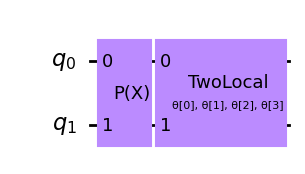

In [ ]:
# @title create of quantum circuits

# from qiskit import BasicAer, ClassicalRegister, QuantumCircuit, execute
# from qiskit.circuit.library import TwoLocal
# from qiskit.quantum_info import random_statevector
# from qiskit_finance.circuit.library.probability_distributions import UniformDistribution, NormalDistribution

# 初期分布作成回路の設定
# 一様分布
init_dist = UniformDistribution(sum(num_qubits))
# 正規分布
# init_dist = NormalDistribution(sum(num_qubits))
# # # ランダム
# init_dist = QuantumCircuit((sum(num_qubits)))
# init_dist.initialize(random_statevector(2**sum(num_qubits)).data, range(sum(num_qubits)))

# 変分量子回路の設定
var_form = TwoLocal(int(np.sum(num_qubits)), "ry", "cz", reps=1)
# 初期分布作成回路と変分量子回路の結合
g_circuit = var_form.compose(init_dist, front=True)

g_circuit.draw("mpl")

--------
### Training

In [ ]:
# from qiskit.utils import QuantumInstance
# from qiskit_machine_learning.algorithms.distribution_learners import NumPyDiscriminator, PyTorchDiscriminator


init_params = [3.0, 1.0, 0.6, 1.6]

qgan.set_generator(generator_circuit=g_circuit, generator_init_params=init_params)

# The parameters have an order issue that following is a temp. workaround
qgan._generator._free_parameters = sorted(g_circuit.parameters, key=lambda p: p.name)

discriminator = PyTorchDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(
    backend=BasicAer.get_backend("statevector_simulator")
)

result = qgan.run(quantum_instance)

print("Training results:")
print("loss_d :", result["loss_d"])
print("loss_g :", result["loss_d"])
print("rel_entr", result["rel_entr"])


<ipython-input-5-dd8f7be0fe92>:17: DeprecationWarning: The __init__ function is deprecated as of version 0.5.0 and will be removed no sooner than 3 months after the release with no direct replacement for it. Instead, please refer to the new QGAN tutorial.
  discriminator = PyTorchDiscriminator(len(num_qubits))
<ipython-input-5-dd8f7be0fe92>:21: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  quantum_instance = QuantumInstance(


Training results:
loss_d : 0.6918
loss_g : 0.6918
rel_entr 0.0994


generated prob. : [0.014 0.55  0.21  0.226]


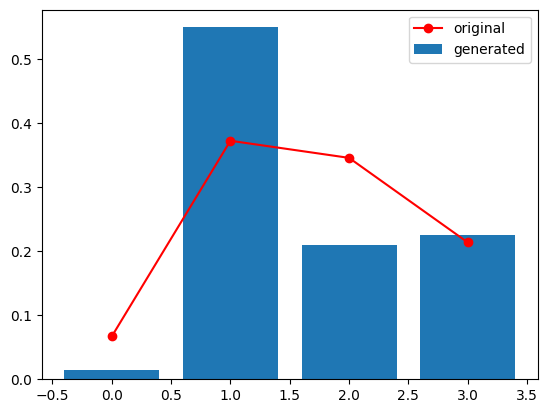

In [ ]:
import matplotlib.pyplot as plt

samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
print("generated prob. :", np.array(prob_g).round(3))
plt.bar(np.array(samples_g).flatten(), prob_g, label="generated")
plt.plot(prob_data, "-o", c="r", label="original")
plt.legend(loc="best")
plt.show()

In [ ]:
# @title version

%load_ext watermark
%watermark

Last updated: 2023-08-21T10:10:34.229916+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.109+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

